In [1]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
def velocity_distribution(Y: List[float], Z: List[float], wl: float, Q: float, n_ybins:int=150, n_zbins:int=150):
    """
    Calculates the 'perfect' velocity distribution in cross section for a given water level and discharge.
    This assumes: no inertia, no viscosity
    :param Y: Y-array of cross section (m) - List[float]
    :param Z: Z-array of cross section (same length as Y) (mAD) - List[float]
    :param wl: Water level (mAD) - float
    :param Q: Discharge to distribute over cross section (m3/s) - float
    :param n_ybins: Discretise y in this number of bins (default: 150) - int
    :param n_zbins: Discretise z in this number of bins (default: 150) - int
    :return: crosssection_Y, crosssection_Z, depth_bins, wl, u
    """

    # Profile YZ
    crosssection_Y = np.linspace(np.min(Y), np.max(Y), n_ybins)
    crosssection_Z = np.interp(crosssection_Y, Y, Z)

    # Level to depth
    crosssection_depth = np.clip(wl - crosssection_Z, 0, np.inf)

    # Create z-grid for cross section: distance to water
    depth_bins = np.linspace(0, np.max(crosssection_depth), n_zbins)

    # Get resolutions of the grid
    dY = crosssection_Y[1] - crosssection_Y[0]
    dZ = depth_bins[1] - depth_bins[0]

    # Create normalised distribution of specific discharge
    q_distr = dY * crosssection_depth ** (3 / 2)
    q_distr_norm = q_distr / np.sum(q_distr)

    # Compute cross section for given discharge
    q = q_distr_norm * (Q / dY)
     # Specific discharge to depth average velocity (catch division by 0 to nan without posting errors)
    with np.errstate(divide='ignore', invalid='ignore'):
        u_mean = q / crosssection_depth

            # Some input for the shape of the profile
    C = 50
    g = 9.81
    kappa = 0.41
    n = 7

    u = []
    for u_mean_dh, d_dh, q_dh in zip(u_mean, crosssection_depth, q):
        if d_dh == 0:
            u_dh = np.full(np.shape(depth_bins), np.nan)
        else:
            u_star = np.sqrt(g / C ** 2 * u_mean_dh ** 2)

            # Distance to bed
            z_dh = d_dh - depth_bins

            # Some part of the profile have a negative depth, they are catched as nans.
            with np.errstate(divide='ignore', invalid='ignore'):
                u_dh = n * u_star / kappa * (z_dh / d_dh) ** (1 / n)

            # Normalise with specific discahrge from chezy formula.
            # My input probably not correct...  Why is this necessary?
            u_dh *= q_dh / np.nansum(u_dh * dZ)

        u.append(u_dh)

    return crosssection_Y, crosssection_Z, depth_bins, u

In [3]:
def plot_velocity_distribution(crosssection_Y, crosssection_Z, depth_bins, wl, u):

    f, ax = plt.subplots()
    
    # Pcolor, contour and labels on contour
    c = plt.pcolor(crosssection_Y, wl - depth_bins, np.transpose(u), cmap='magma', shading='auto')
    cs = plt.contour(crosssection_Y, wl - depth_bins, np.transpose(u), colors='w', linewidths=0.5, levels=np.arange(0, 5, 0.05))
    ax.clabel(cs, fmt='%0.2f', colors='w', fontsize=8)

    # Add colorbar
    cbar = f.colorbar(c, ax=ax)
    cbar.set_label('Flow velocity (m/s)')

    # Add cross section
    plt.plot(crosssection_Y, crosssection_Z, c='k')

    # Mark water level
    crosssection_depth = wl - crosssection_Z
    ii = (crosssection_depth > 0)
    plt.plot(crosssection_Y[ii], (12*ii)[ii] , lw=5, color='#1d91c0')

    plt.ylabel('level (m+NAP)')
    plt.grid(c='#DDDDDD', alpha=0.4)
    plt.xlabel('transect (m)')

    plt.savefig('velocity_distribution.png', dpi=150, bbox_inches='tight')


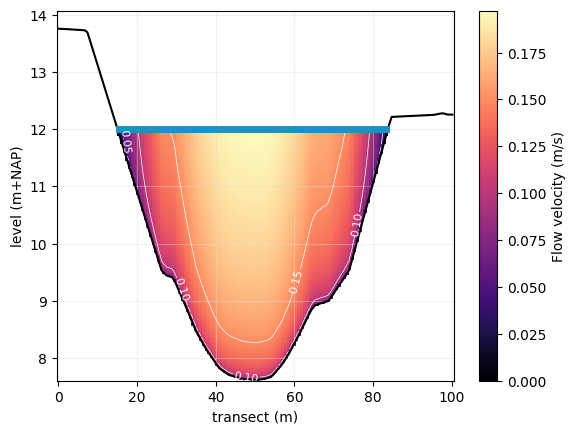

In [5]:
if __name__ == "__main__":

    cs_file = open(r'N:\Projects\11208000\11208005\F. Other information\025- EFlows\CrossSections\klompenerwaard_1.txt')
    cs = pd.read_csv(cs_file, delimiter='\t')
    cs = cs.rename(columns={'X': 'Y', 'Graphic Profile 1': 'Z'})

    wl = 12
    Q = 30

    crosssection_Y, crosssection_Z, depth_bins, u = velocity_distribution(cs['Y'], cs['Z'], wl, Q)

    plot_velocity_distribution(crosssection_Y, crosssection_Z, depth_bins, wl, u)
